In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import time

/Users/hudongyue/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/8l/73hx55c95lb5pt533_s7mbvc0000gn/T/ipykernel_47658/1906489871.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (htt

In [2]:
# !pip install folium
# !pip install shapely
# !pip install geopandas

# Data Loading

In [3]:
df_train = pd.read_csv("train.csv")

In [4]:
df_primary = pd.read_csv("auxiliary-data/sg-primary-schools.csv")
df_primary = df_primary.reset_index()
df_primary['id'] = df_primary['index']
df_primary = df_primary.drop('index', axis=1)
df_primary.head()

,name,lat,lng,id
0,Admiralty Primary School,1.442941,103.800345,0
1,Ahmad Ibrahim Primary School,1.433849,103.832710,1
2,Ai Tong School,1.360713,103.833018,2
3,Alexandra Primary School,1.291284,103.824066,3
4,Anchor Green Primary School,1.390380,103.887354,4


In [5]:
df_secondary = pd.read_csv("auxiliary-data/sg-secondary-schools.csv")
df_secondary = df_secondary.reset_index()
df_secondary['id'] = df_secondary['index']
df_secondary = df_secondary.drop('index', axis=1)
df_secondary.head()

,name,lat,lng,id
0,Admiralty Secondary School,1.445912,103.802908,0
1,Ahmad Ibrahim Secondary School,1.436095,103.830055,1
2,Anderson Secondary School,1.375417,103.851723,2
3,Anglican High School,1.330218,103.941759,3
4,Anglo-Chinese School (Barker Road),1.319709,103.835661,4


In [6]:
df_shopping = pd.read_csv("auxiliary-data/sg-shopping-malls.csv")
df_shopping = df_shopping.reset_index()
df_shopping['id'] = df_shopping['index']
df_shopping = df_shopping.drop('index', axis=1)
df_shopping.head()

,name,lat,lng,wikipedia_link,id
0,100 AM,1.275012,103.841372,NaN,0
1,313@Somerset,1.301013,103.838540,NaN,1
2,Aperia,1.309714,103.863837,NaN,2
3,Balestier Hill Shopping Centre,1.325442,103.842521,NaN,3
4,Bugis Cube,1.298276,103.855555,NaN,4


In [7]:
# find 3 most closest primary school for each flat
def distance(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
    return c * r


def isClose(lat1, lon1, lat2, lon2):
    if abs(lat1 - lat2) < threshold and abs(lon1 - lon2) < threshold:
        return True
    return False

def addClosetPrimarySchool(lat, lon):
    res = []
    for i in range(len(df_primary)):
        point = df_primary.loc[i,['lat','lng']].values 
        if isClose(lat, lon, point[0], point[1]):
            res.append(df_primary.loc[i,['id']].values[0])
    return res

def closePri(row):
    return addClosetPrimarySchool(row['latitude'], row['longitude'])

threshold = 0.004

# start_time = time.time()
# # your code goes here
# df_train_s['closePrimary'] = df_train_s.apply(closePri, axis = 1)
# end_time = time.time()
# elapsed_time = end_time - start_time
# print("run {} rows for time {}".format(len(df_train_s),elapsed_time))
# df_train_s.head()

In [8]:
df_train = df_train.rename(columns = {"longitude" : "lng", "latitude" : "lat"})
df_train['geometry'] = df_train.apply(lambda row: Point(row['lng'], row['lat']), axis = 1)
df_primary['geometry'] = df_primary.apply(lambda row: Point(row['lng'], row['lat']), axis = 1)
df_secondary['geometry'] = df_secondary.apply(lambda row: Point(row['lng'], row['lat']), axis = 1)
df_shopping['geometry'] = df_shopping.apply(lambda row: Point(row['lng'], row['lat']), axis = 1)

#convert pandas to geopandas
df_train_geo = gpd.GeoDataFrame(df_train, geometry = 'geometry')
df_primary_geo = gpd.GeoDataFrame(df_primary, geometry = 'geometry')
df_secondary_geo = gpd.GeoDataFrame(df_secondary, geometry = 'geometry')
df_shopping_geo = gpd.GeoDataFrame(df_shopping, geometry = 'geometry')

In [9]:
df_train_geo.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,lat,lng,elevation,subzone,planning_area,region,resale_price,geometry
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,1.369008,103.958697,0.0,pasir ris drive,pasir ris,east region,209700.0,POINT (103.95870 1.36901)
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,1.399007,103.906991,0.0,punggol field,punggol,north-east region,402300.0,POINT (103.90699 1.39901)
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,1.388348,103.873815,0.0,fernvale,sengkang,north-east region,351000.0,POINT (103.87381 1.38835)
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,1.318493,103.766702,0.0,clementi north,clementi,west region,151200.0,POINT (103.76670 1.31849)
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,1.348149,103.742658,0.0,bukit batok west,bukit batok,west region,318600.0,POINT (103.74266 1.34815)


In [10]:
df_primary_geo.head()

,name,lat,lng,id,geometry
0,Admiralty Primary School,1.442941,103.800345,0,POINT (103.80035 1.44294)
1,Ahmad Ibrahim Primary School,1.433849,103.832710,1,POINT (103.83271 1.43385)
2,Ai Tong School,1.360713,103.833018,2,POINT (103.83302 1.36071)
3,Alexandra Primary School,1.291284,103.824066,3,POINT (103.82407 1.29128)
4,Anchor Green Primary School,1.390380,103.887354,4,POINT (103.88735 1.39038)


In [11]:
import geopandas as gpd
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree
from shapely.geometry import Point

gpd1 = gpd.GeoDataFrame([['John', 1, Point(1, 1)], ['Smith', 1, Point(2, 2)],
                         ['Soap', 1, Point(0, 2)]],
                        columns=['Name', 'ID', 'geometry'])
gpd2 = gpd.GeoDataFrame([['Work', Point(0, 1.1)], ['Shops', Point(2.5, 2)],
                         ['Home', Point(1, 1.1)]],
                        columns=['Place', 'geometry'])



def ckdnearest(gdA, gdB, k, distance_threshold):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    
    kNearest = range(1, k+1)
    
#     dist is the distance array, idx is the index array
    dist, idx = btree.query(nA, kNearest)

    gdB_nearest = gdB.iloc[idx[:,0]].drop(columns="geometry").reset_index(drop=True)
    
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(list(idx), name='closedIndex'),
            pd.Series(dist[:,0], name='dist')
        ], 
        axis=1)

    gdf['inRangeCount'] = 0
    distRange = 1
    for i in range(k):
        gdf['inRangeCount'] = np.where(dist[:, i-1]< distance_threshold, gdf['inRangeCount'] + 1, gdf['inRangeCount'])
        
    gdf['closedIndex'] = gdf.apply(
        lambda row: row['closedIndex'][0: row['inRangeCount']], axis=1)
   
    return gdf
    


ckdnearest(gpd1, gpd2, 2, 1.2 )



,Name,ID,geometry,Place,closedIndex,dist,inRangeCount
0,John,1,POINT (1.00000 1.00000),Home,"[2, 0]",0.1,2
1,Smith,1,POINT (2.00000 2.00000),Shops,[1],0.5,1
2,Soap,1,POINT (0.00000 2.00000),Work,[0],0.9,1


In [41]:
df_train_primary = ckdnearest(df_train_geo, df_primary_geo, 10, 0.010)
df_train_primary = df_train_primary.rename(columns = {"closedIndex" : "closePrimaryID", 
                                   "inRangeCount" : "nearPrimaryCount", 
                                   "dist": "MinPrimaryDist"})
df_train_primary.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,region,resale_price,geometry,name,lat,lng,id,closePrimaryID,MinPrimaryDist,nearPrimaryCount
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,...,east region,209700.0,POINT (103.95870 1.36901),Loyang Primary School,1.370879,103.956231,89,"[89, 22, 173, 115, 39]",0.003095,5
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,...,north-east region,402300.0,POINT (103.90699 1.39901),Edgefield Primary School,1.400350,103.907527,48,"[48, 96, 136, 72, 64, 127, 111, 125]",0.001447,8
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,...,north-east region,351000.0,POINT (103.87381 1.38835),Fernvale Primary School,1.389963,103.874211,56,"[56, 140]",0.001663,2
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,...,west region,151200.0,POINT (103.76670 1.31849),Pei Tong Primary School,1.316004,103.767845,119,"[119, 36]",0.002739,2
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,...,west region,318600.0,POINT (103.74266 1.34815),Princess Elizabeth Primary School,1.349382,103.740954,123,"[123, 186, 79]",0.002103,3


In [33]:
df_train_secondary = ckdnearest(df_train_geo, df_secondary_geo, 5, 0.015)
df_train_secondary = df_train_secondary.rename(columns = {"closedIndex" : "closeSecondID", 
                                   "inRangeCount" : "nearSecondCount", 
                                   "dist": "MinSecDist"})
df_train_secondary.head()

KeyboardInterrupt: 

In [14]:
df_train_shopping = ckdnearest(df_train_geo, df_shopping_geo, 5, 0.025)
df_train_shopping = df_train_shopping.rename(columns = {"closedIndex" : "closeShopID", 
                                   "inRangeCount" : "nearShopCount", 
                                   "dist": "MinShopDist"})

df_train_shopping.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,resale_price,geometry,name,lat,lng,wikipedia_link,id,closeShopID,MinShopDist,nearShopCount
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,...,209700.0,POINT (103.95870 1.36901),Downtown East,1.377372,103.954648,/wiki/NTUC_Downtown_East,68,"[68, 67, 93, 94, 70]",0.009292,5
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,...,402300.0,POINT (103.90699 1.39901),Rivervale Mall,1.392245,103.904378,NaN,125,"[125, 123, 124, 126, 114]",0.007249,5
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,...,351000.0,POINT (103.87381 1.38835),The Seletar Mall,1.391773,103.876015,/wiki/Seletar_Mall,127,"[127, 119, 128, 121, 115]",0.004070,5
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,...,151200.0,POINT (103.76670 1.31849),The Clementi Mall,1.315029,103.764498,/wiki/Clementi_Mall,154,"[154, 153, 167, 172, 134]",0.004106,5
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,...,318600.0,POINT (103.74266 1.34815),West Mall,1.350076,103.749257,/wiki/West_Mall,145,"[145, 155, 157, 156, 164]",0.006874,5


In [15]:
#Merge Three Tables
# df_train_primary= df_train_primary.drop(columns=['geometry', 'name', 'id'])
# df_train_secondary = df_train_secondary.drop(columns= ['geometry', 'name', 'id'])
# df_train_shopping = df_train_shopping.drop(columns= ['geometry', 'name', 'id', 'wikipedia_link'])

df_merge = pd.concat(
        [
            df_train_primary,
            df_train_secondary[['closeSecondID', 'MinSecDist', 'nearSecondCount']],
            df_train_shopping[['closeShopID', 'MinShopDist', 'nearShopCount']]

        ], 
        axis=1)
df_merge.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,id,closePrimaryID,MinPrimaryDist,nearPrimaryCount,closeSecondID,MinSecDist,nearSecondCount,closeShopID,MinShopDist,nearShopCount
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,...,89,"[89, 22, 173, 115, 39, 156, 49, 63, 46, 187]",0.003095,10,"[91, 70, 55, 42, 43]",0.003852,5,"[68, 67, 93, 94, 70]",0.009292,5
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,...,48,"[48, 96, 136, 72, 64, 127, 111, 125, 37, 167]",0.001447,10,"[75, 99, 52, 44, 36]",0.002810,5,"[125, 123, 124, 126, 114]",0.007249,5
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,...,56,"[56, 140, 73, 4, 137, 183, 146, 100, 113, 179]",0.001663,10,"[94, 59, 78, 15, 140]",0.005023,5,"[127, 119, 128, 121, 115]",0.004070,5
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,...,119,"[119, 36, 128, 101, 70, 17]",0.002739,6,"[34, 109, 79, 83, 88]",0.005569,5,"[154, 153, 167, 172, 134]",0.004106,5
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,...,123,"[123, 186, 79, 88, 18, 43, 60, 82, 150]",0.002103,9,"[17, 115, 20, 56, 65]",0.001960,5,"[145, 155, 157, 156, 164]",0.006874,5


In [16]:
df_merge.to_csv("mergePriSecShop.csv")

# Visualization 

In [17]:
import folium
# List of points (latitude, longitude)
a = df_primary[['lat','lng']].mean().values
# Create a map object centered on the first point
m = folium.Map(location=a, zoom_start=11.5)

#Add a marker for each point
for i in range(len(df_primary)):
    point = df_primary.loc[i,['lat','lng']].values 
    name = df_primary.loc[i,['name']].values[0] 
    folium.Marker(location=point, popup = name + "" + str(point)).add_to(m) 
# Display the map


In [18]:
df_merge.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'eco_category', 'lease_commence_date',
       'lat', 'lng', 'elevation', 'subzone', 'planning_area', 'region',
       'resale_price', 'geometry', 'name', 'lat', 'lng', 'id',
       'closePrimaryID', 'MinPrimaryDist', 'nearPrimaryCount', 'closeSecondID',
       'MinSecDist', 'nearSecondCount', 'closeShopID', 'MinShopDist',
       'nearShopCount'],
      dtype='object')

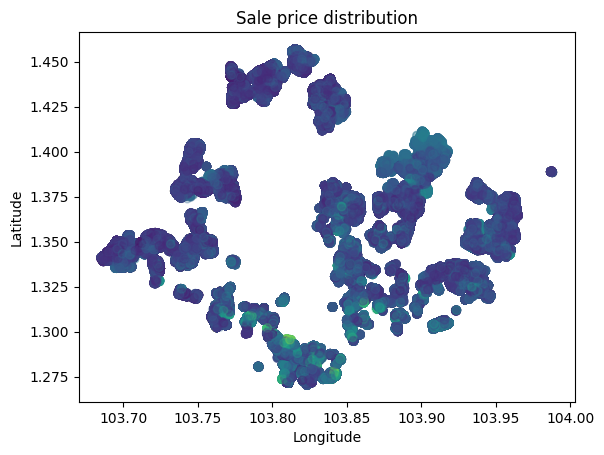

In [19]:
# See the resale price / square meters distribution
df_merge = df_merge.loc[:,~df_merge.columns.duplicated()].copy()
sale_price = df_merge['resale_price'] / df_merge['floor_area_sqm']
longitude = df_merge['lng'].values
latitude = df_merge['lat']

# Create a scatter plot
plt.scatter(longitude, latitude, c=sale_price, alpha=0.3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sale price distribution')


plt.show()

In [20]:
# compare the relationship between the near school
df_top = pd.read_csv('auxiliary-data/top10-primary.csv')
df_top

,School Name,Percentage
0,Pei Hwa Presbyterian Primary School,255%
1,Gongshang Primary School,197%
2,Riverside Primary School,153%
3,Red Swastika School,147%
4,Punggol Green Primary School,146%
5,Princess Elizabeth Primary School,143%
6,Westwood Primary School,139%
7,Ai Tong School,133%
8,Frontier Primary School,131%
9,Oasis Primary School,NaN


In [21]:
df_primary.head()

,name,lat,lng,id,geometry
0,Admiralty Primary School,1.442941,103.800345,0,POINT (103.80035 1.44294)
1,Ahmad Ibrahim Primary School,1.433849,103.832710,1,POINT (103.83271 1.43385)
2,Ai Tong School,1.360713,103.833018,2,POINT (103.83302 1.36071)
3,Alexandra Primary School,1.291284,103.824066,3,POINT (103.82407 1.29128)
4,Anchor Green Primary School,1.390380,103.887354,4,POINT (103.88735 1.39038)


In [22]:
mask = df_primary['name'].isin(df_top['School Name'])

# get the indices of the matching values in B
indices = np.where(mask)[0]

# print the indices
print(indices)

[  2   7  58  63  70 101 102 111 118 123 125 133 134 137 159 171]


In [23]:
# define a lambda function to compute the intersection
intersection_func = lambda row: len(np.intersect1d(row['closePrimaryID'], indices))

# apply the lambda function to create a new column
df_train_primary['nearTopPrimaryCount'] = df_train_primary.apply(intersection_func, axis=1)
df_train_primary.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,resale_price,geometry,name,lat,lng,id,closePrimaryID,MinPrimaryDist,nearPrimaryCount,nearTopPrimaryCount
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,...,209700.0,POINT (103.95870 1.36901),Loyang Primary School,1.370879,103.956231,89,"[89, 22, 173, 115, 39, 156, 49, 63, 46, 187]",0.003095,10,1
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,...,402300.0,POINT (103.90699 1.39901),Edgefield Primary School,1.400350,103.907527,48,"[48, 96, 136, 72, 64, 127, 111, 125, 37, 167]",0.001447,10,2
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,...,351000.0,POINT (103.87381 1.38835),Fernvale Primary School,1.389963,103.874211,56,"[56, 140, 73, 4, 137, 183, 146, 100, 113, 179]",0.001663,10,1
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,...,151200.0,POINT (103.76670 1.31849),Pei Tong Primary School,1.316004,103.767845,119,"[119, 36, 128, 101, 70, 17]",0.002739,6,2
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,...,318600.0,POINT (103.74266 1.34815),Princess Elizabeth Primary School,1.349382,103.740954,123,"[123, 186, 79, 88, 18, 43, 60, 82, 150]",0.002103,9,1


In [38]:
df_train_primary.nearTopPrimaryCount.value_counts()
df_train_primary['priceUnit'] = df_train_primary['resale_price'] / df_train_primary['floor_area_sqm']

AttributeError: 'GeoDataFrame' object has no attribute 'nearTopPrimaryCount'

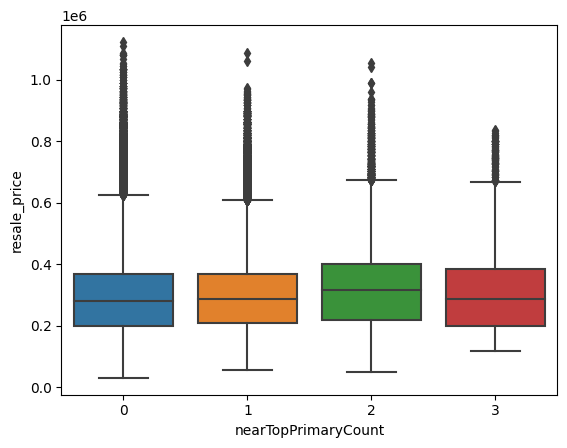

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# assume you have a pandas dataframe called 'data' with columns 'category' and 'sale_price'
# 'category' is the categorical variable you want to plot against the sale price

sns.boxplot(x='nearTopPrimaryCount', y='resale_price', data=df_train_primary)
plt.show()

In [37]:

sns.boxplot(x='nearTopPrimaryCount', y='priceUnit', data=df_train_primary)
plt.show()

ValueError: Could not interpret input 'nearTopPrimaryCount'

In [42]:
df_train_primary.nearPrimaryCount.value_counts()

3     99800
4     96125
2     69565
5     68496
6     32681
1     29055
7     19132
8      8433
0      5773
9      1957
10      715
Name: nearPrimaryCount, dtype: int64

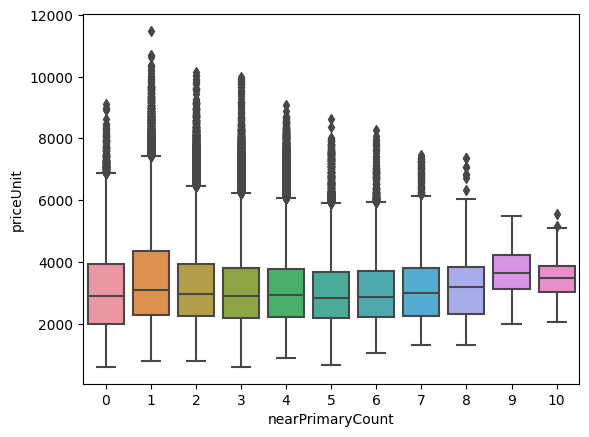

In [43]:
df_train_primary['priceUnit'] = df_train_primary['resale_price'] / df_train_primary['floor_area_sqm']
sns.boxplot(x='nearPrimaryCount', y='priceUnit', data=df_train_primary)
plt.show()

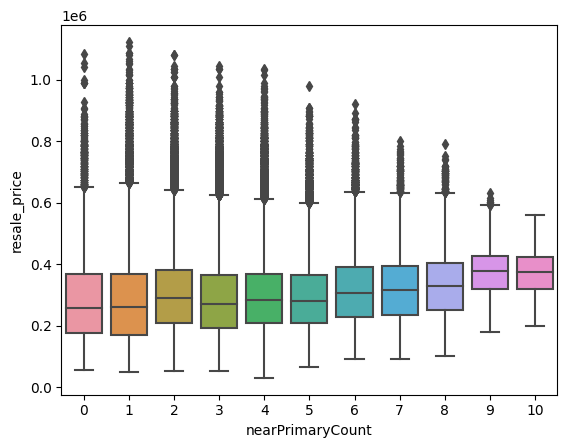

In [44]:
sns.boxplot(x='nearPrimaryCount', y='resale_price', data=df_train_primary)
plt.show()